In [536]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv3D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv3D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame as df

## Load Features Datasets and Restructure

In [487]:
feat = pd.read_csv("../Data/MERRA2/Features.csv").drop(['Unnamed: 0'],axis = 1)
TCcount = pd.read_csv("../Data/TC Count/IBTrACS/IBTrACS(1980-P, 100W-20W&10N-40N).csv")
feat['time'] = pd.to_datetime(feat['time'])
feat = feat.loc[(feat['time'].dt.month <= 5) & (feat['time'].dt.year > 1980) & (feat['time'].dt.year < 2022)]
TCcount = TCcount.loc[(TCcount['SEASON'] > 1980) & (TCcount['SEASON'] < 2022)]
sstFeat = pd.read_csv("../Data/ERSSTv5/ERSSTv5_NotInterpolated.csv")
sstFeat = sstFeat.loc[(sstFeat['month'] <= 5) & (sstFeat['year'] > 1980) & (sstFeat['year'] < 2022)]
sstFeat = sstFeat.drop('Unnamed: 0', axis =1)

In [488]:
### Re-structure dataset into desired format
### Single feature manipulation
slp = feat[['year','month','lon','lat','SLP']]
salt = feat[['year','month','lon','lat','SSSMASS']]
omega = feat[['year','month','lon','lat','OMEGA500']]
wind = feat[['year','month','lon','lat','U500']]

# Get latitude and longitude corrdinates
lats = np.sort(np.unique(slp['lat']))
lons = np.sort(np.unique(slp['lon']))
months = np.unique(slp['month'])
years = np.unique(slp['year'])

In [489]:
# fill in the matrix
x = wind[['U500']].to_numpy().reshape(len(years),len(months),len(lons),len(lats))
# sanity check
x[1,3,4,2] == feat.loc[(feat['year'] == years[1]) & (feat['month'] == months[3]) & (feat['lon'] == lons[4]) & (feat['lat'] == lats[2])]['U500']


204840    True
Name: U500, dtype: bool

In [537]:
# Final format, years * lats * lons * months 
trans_x = np.transpose(x,(0,3,2,1))
trans_x[5,15,45,3] == feat.loc[(feat['year'] == years[5]) & (feat['month'] == months[3]) & (feat['lat'] == lats[15]) & (feat['lon'] == lons[45])]['U500']

585066    True
Name: U500, dtype: bool

In [544]:
def OneFeatCNNModel(months, latNum, lonNum,
             dropoutRate = 0.5, spatialKernelShape = (3,3), 
             C1 = 10, S1 = 10, norm_rate = 0.25, dropoutType = 'Dropout'):
    dropoutType = Dropout
    input1   = Input(shape = (latNum, lonNum, months))

    ##################################################################
    #block1 = BatchNormalization()(input1)
    block1 = Conv2D(filters = 20, kernel_size = spatialKernelShape, padding = 'same',strides = (1,1),
                                   use_bias = False)(input1)
    #block1 = MaxPooling2D((3, 3), padding='same',strides = (1,1))(block1)
    block1 = Activation('relu')(block1)
    block1 = Conv2D(filters = C1, kernel_size = (1,1))(block1)
    block1 = Activation('relu')(block1)
    block1 = MaxPooling2D((3, 3),padding='valid',strides = (1,1))(block1)
    
    block1 = Conv2D(filters = 20, kernel_size = spatialKernelShape, padding = 'same',strides = (1,1),
                                   use_bias = False)(block1)
    #block1 = MaxPooling2D((3, 3), padding='same',strides = (1,1))(block1)
    block1 = Activation('relu')(block1)
    block1 = Conv2D(filters = C1, kernel_size = (1,1))(block1)
    block1 = Activation('relu')(block1)
    block1 = MaxPooling2D((3, 3),padding='valid',strides = (1,1))(block1)
        
    block2 = SeparableConv2D(S1, (4,4),
                                   use_bias = False, padding = 'valid')(block1)
    block2 = Activation('relu')(block2)
    block2 = Conv2D(filters = 4, kernel_size = spatialKernelShape, padding = 'valid',strides = (3,3),)(block2)
    block2 = Activation('relu')(block2)
    block2 = MaxPooling2D((3, 3),padding='valid',strides = (3,3))(block2)
    flatten = Flatten()(block2)
    
    dense1 = Dense(20)(flatten)
    dense2 = Dense(10)(dense1)
    dense3 = Dense(5)(dense2)
    dense4 = Dense(1, activation = 'linear')(dense3)
    
    return Model(inputs=input1, outputs=dense4)

### Train the model

/Users/jackzhang/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


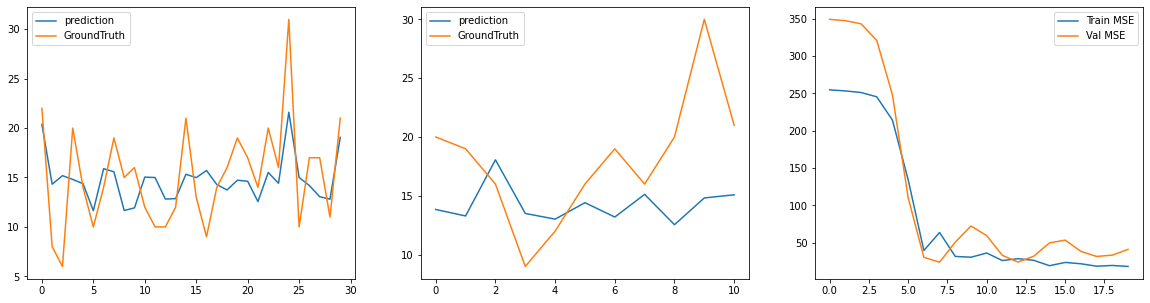

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 61, 129, 5)]      0         
                                                                 
 conv2d_244 (Conv2D)         (None, 61, 129, 20)       900       
                                                                 
 activation_301 (Activation)  (None, 61, 129, 20)      0         
                                                                 
 conv2d_245 (Conv2D)         (None, 61, 129, 10)       210       
                                                                 
 activation_302 (Activation)  (None, 61, 129, 10)      0         
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 59, 127, 10)      0         
 ng2D)                                                           
                                                          

In [559]:
### build a sample model
oneFeatModel = OneFeatCNNModel(len(months),len(lats),len(lons))
optimizer = tf.keras.optimizers.Adam(lr=0.001)
oneFeatModel.compile(optimizer=optimizer,loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
X_train = trans_x[:30]
X_test = trans_x[30:]
y_train = TCcount.iloc[:30]['COUNT']
y_test = TCcount.iloc[30:]['COUNT']
es = EarlyStopping(monitor='val_mean_squared_error', verbose=1, patience = 5,min_delta = 0.0001)
hist = oneFeatModel.fit(X_train, y_train,batch_size=10,epochs = 20, verbose=0,validation_data= (X_test,y_test))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(np.arange(0,30),oneFeatModel.predict(X_train),label = 'prediction')
plt.plot(np.arange(0,30),y_train,label = 'GroundTruth')
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(0,11),oneFeatModel.predict(X_test),label = 'prediction')
plt.plot(np.arange(0,11),y_test,label = 'GroundTruth')
plt.legend()

plt.subplot(1,3,3)
plt.plot(hist.history['mean_squared_error'],label = 'Train MSE')
plt.plot(hist.history['val_mean_squared_error'],label = 'Val MSE')
plt.legend()
plt.show()
oneFeatModel.summary()

### Layer Visualization

In [490]:
oneFeatModel.layers

In [459]:
trans_x.shape

(41, 61, 129, 5)

### SVR and Linear Regression Models

In [110]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [111]:
# Read Nino3.4, QBO, SOI
nino = pd.read_csv("../Data/Indexs/Nino3.4.txt", sep=" ",names = [" ","Year in Decimal","Nino index","1 "]).dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')
soi = pd.read_csv("../Data/Indexs/SOI.txt", sep=" ",names = [" ","Year in Decimal","SOI index","1 "]).dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')
qbo = pd.read_csv("../Data/Indexs/QBO.txt", sep=" ",names = [" ","Year in Decimal","QBO index","1 "]).dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')

def convert_partial_year(number):
    year = int(number)
    d = timedelta(days = ((number - year) * 365)+2)
    day_one = datetime(year, 1, 1)
    date = d + day_one
    return date
nino["Year in dt"] = nino["Year in Decimal"].apply(convert_partial_year)
nino["Year"] = nino["Year in dt"].dt.year
nino["Month"] = nino["Year in dt"].dt.month
nino = nino.loc[(nino['Year'] > 1980) & (nino['Year'] < 2022)]
soi["Year in dt"] = soi["Year in Decimal"].apply(convert_partial_year)
soi["Year"] = soi["Year in dt"].dt.year
soi["Month"] = soi["Year in dt"].dt.month
soi = soi.loc[(soi['Year'] > 1980) & (soi['Year'] < 2022)]
qbo["Year in dt"] = qbo["Year in Decimal"].apply(convert_partial_year)
qbo["Year"] = qbo["Year in dt"].dt.year
qbo["Month"] = qbo["Year in dt"].dt.month
qbo = qbo.loc[(qbo['Year'] > 1980) & (qbo['Year'] < 2022)]


In [343]:
soi_X = np.array(soi.groupby('Year').mean().reset_index()['SOI index']).reshape(41,1)
soi_y = np.array(TCcount['COUNT'][:]).reshape(41,1)
nino_X = np.array(nino.groupby('Year').mean().reset_index()['Nino index']).reshape(41,1)
nino_y = np.array(TCcount['COUNT'][:]).reshape(41,1)
qbo_X = np.array(qbo.groupby('Year').mean().reset_index()['QBO index']).reshape(41,1)
qbo_y = np.array(TCcount['COUNT'][:]).reshape(41,1)

In [344]:
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = sc_X.fit_transform(X)
# y = sc_y.fit_transform(y)
indexs_df = df({'soi': soi_X[:,0], 'nino': nino_X[:,0], 'qbo': qbo_X[:,0]})

In [346]:
import statsmodels.api as sm
import sklearn
def get_stats():
    X = indexs_df[['soi','nino','qbo']]
    results = sm.OLS(soi_y, X).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              159.3
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                    1.45e-21
Time:                        15:31:14   Log-Likelihood:                         -120.27
No. Observations:                  41   AIC:                                      246.5
Df Residuals:                      38   BIC:                                      251.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [347]:
X = indexs_df
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X, soi_y)

LinearRegression()

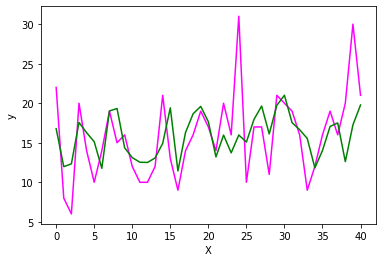

In [348]:
plt.plot(nino_y, color = 'magenta')
plt.plot(linear_model.predict(indexs_df), color = 'green')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [349]:
linear_model.coef_

array([[ 2.23827075, -0.64197307, -0.07303718]])

#### Explore SMLR on Environmental Features

In [350]:
feat.head()

,time,lon,lat,OMEGA500,SLP,U500,SSSMASS,month,year
86559,1981-01-01,-100.0,10.0,0.021865,101288.12,0.068800,5.465323e-08,1,1981
86560,1981-01-01,-100.0,10.5,0.021120,101302.38,0.289666,5.707235e-08,1,1981
86561,1981-01-01,-100.0,11.0,0.020317,101314.88,0.573919,5.961355e-08,1,1981
86562,1981-01-01,-100.0,11.5,0.019704,101325.80,0.992850,6.157003e-08,1,1981
86563,1981-01-01,-100.0,12.0,0.019548,101336.22,1.548453,6.336287e-08,1,1981


In [357]:
feat_smlr = feat
feat_smlr = feat_smlr.loc[feat_smlr['month'] == 3][['year','OMEGA500','SLP','U500','SSSMASS']].groupby('year').mean().reset_index().drop('year',axis = 1)
feat_smlr['SLP'] = feat_smlr['SLP']
feat_smlr['SSSMASS'] = feat_smlr['SSSMASS']
sst_smlr = sstFeat[['year','ssta']].groupby('year').mean().reset_index().drop('year',axis = 1)
feat_smlr['ssta'] = sst_smlr['ssta']

In [358]:
def get_stats():
    X = feat_smlr[['OMEGA500','SLP','U500','SSSMASS','ssta']]
    results = sm.OLS(soi_y, X).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              99.99
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                    4.46e-20
Time:                        15:33:20   Log-Likelihood:                         -118.38
No. Observations:                  41   AIC:                                      246.8
Df Residuals:                      36   BIC:                                      255.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

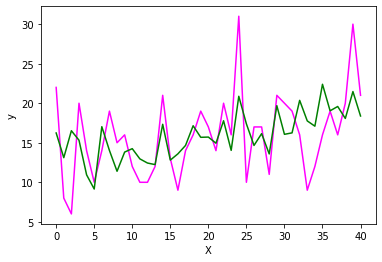

In [359]:
X = feat_smlr[['SLP','U500','SSSMASS','ssta']]
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X, soi_y)
plt.plot(soi_y, color = 'magenta')
plt.plot(linear_model.predict(X), color = 'green')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [360]:
linear_model.coef_

array([[-4.29946189e-03,  4.71824154e-01, -1.78811134e+08,
         1.14889217e+01]])

### MLR with all feats

In [361]:
feat_smlr[['soi','nino','qbo']] = indexs_df[['soi','nino','qbo']]

In [425]:
def get_stats():
    X = feat_smlr
    results = sm.OLS(soi_y, X).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              83.45
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                    1.17e-19
Time:                        15:38:14   Log-Likelihood:                         -111.10
No. Observations:                  41   AIC:                                      238.2
Df Residuals:                      33   BIC:                                      251.9
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

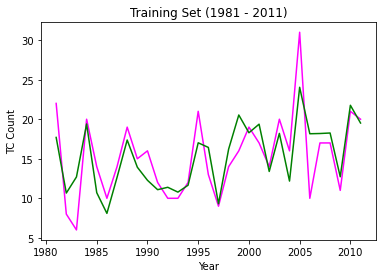

In [446]:
X = feat_smlr
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X.iloc[:-10], soi_y[:-10])
plt.plot(np.arange(1981,2012,1),soi_y[:-10], color = 'magenta')
plt.plot(np.arange(1981,2012,1),linear_model.predict(X.iloc[:-10]), color = 'green')
plt.title('Training Set (1981 - 2011)')
plt.xlabel('Year')
plt.ylabel('TC Count')
plt.show()

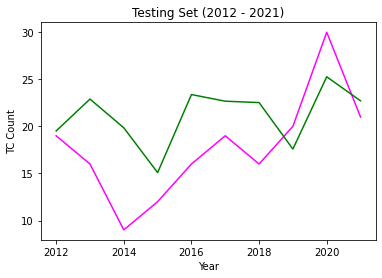

In [447]:
plt.plot(np.arange(2012,2022),soi_y[-10:], color = 'magenta')
plt.plot(np.arange(2012,2022),linear_model.predict(X.iloc[-10:]), color = 'green')
plt.title('Testing Set (2012 - 2021)')
plt.xlabel('Year')
plt.ylabel('TC Count')
plt.show()

In [457]:
from sklearn.metrics import mean_squared_error
print("MSE of Testing Set is" ,mean_squared_error(soi_y[-10:],linear_model.predict(X.iloc[-10:])))

MSE of Testing Set is 31.677814455981327


In [458]:
print("MSE of Training Set is",mean_squared_error(soi_y[:-10],linear_model.predict(X.iloc[:-10])))

MSE of Training Set is 9.928336361653688
